In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import cv2
import shutil
import sys
from PIL import Image
from skimage.io import imshow
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch

sys.path.append('../')
from CycleGAN.models import *
from CycleGAN.models import Generator
from CycleGAN.datasets import ImageDataset

###  Выделяем лица на фото

In [4]:
# !wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_eye.xml -P ./
# !wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml -P ./
# !wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt.xml -P ./

In [5]:
def crop_faces_and_save(input_path, output_path):
    image_path = input_path

    def save_faces(cascade, imgname):
        img = cv2.imread(os.path.join(image_path, imgname))
        for i, face in enumerate(cascade.detectMultiScale(img)):
            x, y, w, h = face
            sub_face = img[y:y + h, x:x + w]
            cv2.imwrite(os.path.join(output_path, "{}".format(imgname)), sub_face)
            break


    face_cascade = "haarcascade_frontalface_default.xml"
    cascade = cv2.CascadeClassifier(face_cascade)
    # Iterate through files
    for i, f in enumerate([f for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path, f))]):
        save_faces(cascade, f)
        if i > 3000:
            break

In [ ]:
crop_faces_and_save('../datasets/train_A', '../datasets/crop/train_A')
crop_faces_and_save('../datasets/train_B', '../datasets/crop/train_B')

In [6]:
BATCHSIZE = 1
LR = 0.0002
DECAY_EPOCH  = 100
SIZE = 256
INPUT_NC = 3
OUTPUT_NC = 3
CUDA = False
N_CPU = 8
DATAROOT = '../datasets/crop/'
GENERATOR_A2B = '../models/netG_A2B-final.pth'
GENERATOR_B2A = '../models/netG_B2A-final.pth'


In [7]:
netG_A2B = Generator(INPUT_NC, OUTPUT_NC)
netG_B2A = Generator(OUTPUT_NC, INPUT_NC)

if CUDA:
    netG_A2B.cuda()
    netG_B2A.cuda()

# Load state dicts
netG_A2B.load_state_dict(torch.load(GENERATOR_A2B, map_location='cpu'))
netG_B2A.load_state_dict(torch.load(GENERATOR_B2A, map_location='cpu'))

# Set model's test mode
netG_A2B.eval()
netG_B2A.eval()

# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if CUDA else torch.Tensor
input_A = Tensor(BATCHSIZE, INPUT_NC, SIZE, SIZE)
input_B = Tensor(BATCHSIZE, OUTPUT_NC, SIZE, SIZE)

# Dataset loader
transforms_ = [ transforms.Resize(int(SIZE*1.12), Image.BICUBIC),
                transforms.RandomCrop(SIZE),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
dataloader = DataLoader(ImageDataset(DATAROOT, transforms_=transforms_, mode='train'),
                        batch_size=BATCHSIZE, shuffle=False, num_workers=N_CPU)
###################################

###### Testing######

# Create output dirs if they don't exist
if not os.path.exists('output/A'):
    os.makedirs('output/A')
if not os.path.exists('output/B'):
    os.makedirs('output/B')

for i, batch in enumerate(dataloader):
    # Set model input
    real_A = Variable(input_A.copy_(batch['A']))
    real_B = Variable(input_B.copy_(batch['B']))

    # Generate output
    fake_B = 0.5*(netG_A2B(netG_A2B(real_A)).data + 1.0)
    fake_A = 0.5*(netG_B2A(netG_B2A(real_B)).data + 1.0)

    # Save image files
    save_image(fake_A, 'output/A/%04d.png' % (i+1))
    save_image(fake_B, 'output/B/%04d.png' % (i+1))


['../datasets/crop/train_A/000001.jpg', '../datasets/crop/train_A/000002.jpg', '../datasets/crop/train_A/000009.jpg', '../datasets/crop/train_A/000011.jpg', '../datasets/crop/train_A/000012.jpg', '../datasets/crop/train_A/000013.jpg', '../datasets/crop/train_A/000014.jpg', '../datasets/crop/train_A/000016.jpg', '../datasets/crop/train_A/000017.jpg', '../datasets/crop/train_A/000018.jpg']


In [8]:
B_files = sorted(os.listdir('../datasets/crop/train_B'))[1:]
A_files = sorted(os.listdir('../datasets/crop/train_A'))[1:]

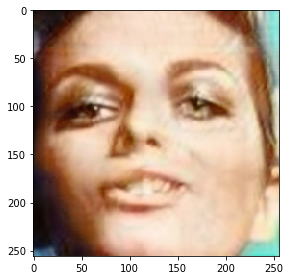

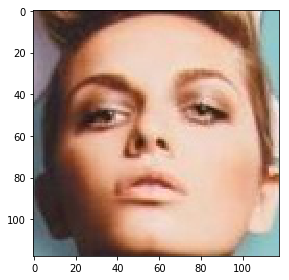

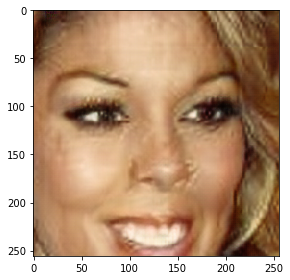

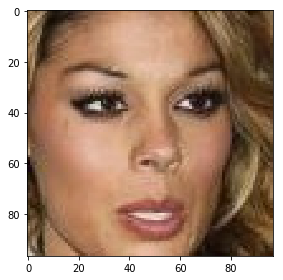

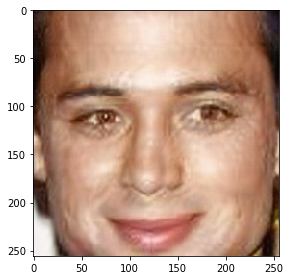

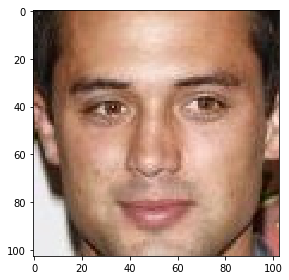

In [14]:
for i in range(3, 6):
    if i < 10:
        imshow('./output/A/000%s.png'%i)
    plt.show()
    imshow('../Datasets/crop/train_B/' + B_files[i - 2])
    plt.show()

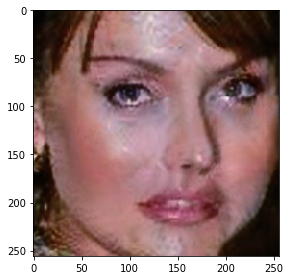

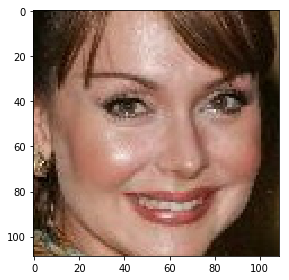

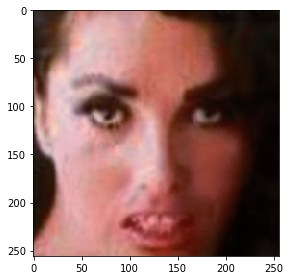

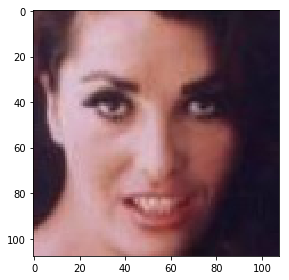

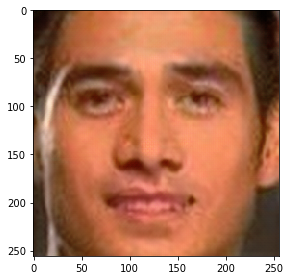

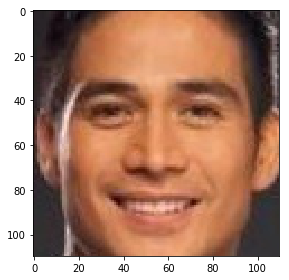

In [15]:
for i in range(3, 6):
    if i < 10:
        imshow('./output/B/000%s.png'%i)
    plt.show()
    imshow('../Datasets/crop/train_A/' + A_files[i - 2])
    plt.show()